## This code was run using the PyTorch 2.4.0 Kernel on Rivanna HPC

We use WandB (weights and biases) to log our model performance and generate the figures in our paper. It is encouraged that those reproducing these results create a wandb account, install wandb, and use `wandb login` to set up logging. However, if you would like to skip this, please remove code involving wandb from the training loop and the notebook should run without problem.

In [1]:
import wandb

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.models.video import swin_transformer, Swin3D_B_Weights

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
X = torch.load(dirpath+'X_upscaled_tensor.pt')
Y = torch.load(dirpath+'Y_tensor.pt')

In [4]:
X.shape, Y.shape

(torch.Size([112, 25, 3, 224, 224]), torch.Size([112, 126]))

In [5]:
# Need to reshape to [B, C, N, W, H] for Swin Transformer
X = X.permute(0, 2, 1, 3, 4)

In [6]:
X.shape, Y.shape

(torch.Size([112, 3, 25, 224, 224]), torch.Size([112, 126]))

In [7]:
class TOCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: torch.Tensor of shape (N, 25, 224, 224) - videos
        Y: torch.Tensor of shape (N, 126) - target curves
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]
        curve = self.Y[idx]
        return video, curve

In [8]:
# Create dataset and data loader
dataset = TOCDataset(X, Y)
train_size = int(6/7 * len(dataset))
test_size = len(dataset) - train_size
bs = 8

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [9]:
# Custom weight initialization to scale down weights
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, a=-0.01, b=0.01)  # Small weights
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)

In [10]:
model = swin_transformer.swin3d_b(weights=None)  
# change model head to output a 126-dim vector corresponding to the TOS curve
model.head = nn.Linear(model.head.in_features, 126)
model = model.apply(init_weights)

In [11]:
# READ:
#    ATTEMPTED EFFORT TO FREEZE TRANSFORMER AND TRAIN ITS HEAD AS AN MLP FOR BETTER PERFORMANCE
#    FAILED EXPERIMENT, BAD RESULTS
_ = """
# Initialize SwinTransformer3D base model
model = swin_transformer.swin3d_b(weights=Swin3D_B_Weights.KINETICS400_V1)  
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512), 
    nn.Tanh(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 126),
    nn.Tanh()
)

model.head.apply(init_weights)

for name, param in model.named_parameters():
    if not name.startswith("head"):  # Freeze all parameters except the head
        param.requires_grad = False
"""

In [12]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
# Loss function, optimizer
criterion = nn.MSELoss()  # Use MSELoss for regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
# Initialize W&B
wandb.init(
    project="MLIA",  # Replace with your W&B project name
    name="SwinFrozen",
    config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        # READ: Max_norm was used for gradient clipping, but we found it ineffective
        #"max_norm": 0.5,
        "num_epochs": 500,
        "patience": 15,
    },
)
config = wandb.config

# Early stopping setup
patience = config.patience
best_train_loss = float("inf")
patience_counter = 0
best_model_weights = None

# Function to calculate parameter norm
def calculate_param_norm(model, norm_type=2):
    total_norm = 0.0
    for param in model.parameters():
        if param.requires_grad:
            param_norm = param.norm(norm_type)
            total_norm += param_norm.item() ** norm_type
    return total_norm ** (1.0 / norm_type)

# Training loop
num_epochs = config.num_epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, curves in train_loader:
        videos, curves = videos.to(device), curves.to(device)

        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, curves)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.max_norm)

        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            valid_loss += criterion(outputs, labels).item()
    avg_valid_loss = valid_loss / len(test_loader)
    model.train()

    # Calculate parameter norm
    param_norm = calculate_param_norm(model)

    # Log metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "valid_loss": avg_valid_loss,
        "param_norm": param_norm,  # Log parameter norm
    })

    # Early stopping logic
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        patience_counter = 0
        best_model_weights = model.state_dict()  # Save the best model weights
        # Save best model to W&B
        wandb.run.summary["best_train_loss"] = best_train_loss
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Validation loss did not improve for {patience} epochs.")
            wandb.run.summary["early_stopping_epoch"] = epoch + 1
            break

    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Param Norm: {param_norm:.4f}")

# Restore the best model weights after training
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored the best model weights.")

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bae9wk (crg). Use `wandb login --relogin` to force relogin


Epoch 0/500 - Train Loss: 1243.8012, Param Norm: 179.2417
Epoch 5/500 - Train Loss: 946.5377, Param Norm: 179.3506
Epoch 10/500 - Train Loss: 717.7220, Param Norm: 179.4363
Epoch 15/500 - Train Loss: 560.8913, Param Norm: 179.5213
Epoch 20/500 - Train Loss: 452.8597, Param Norm: 179.5995
Epoch 25/500 - Train Loss: 377.6199, Param Norm: 179.6687
Epoch 30/500 - Train Loss: 325.4140, Param Norm: 179.7283
Epoch 35/500 - Train Loss: 290.1561, Param Norm: 179.7821
Epoch 40/500 - Train Loss: 266.7515, Param Norm: 179.8259
Epoch 45/500 - Train Loss: 252.1015, Param Norm: 179.8648
Epoch 50/500 - Train Loss: 243.4253, Param Norm: 179.9241
Epoch 55/500 - Train Loss: 237.9738, Param Norm: 179.9607
Epoch 60/500 - Train Loss: 234.9080, Param Norm: 179.9783
Epoch 65/500 - Train Loss: 233.2185, Param Norm: 179.9904
Epoch 70/500 - Train Loss: 232.4601, Param Norm: 179.9996
Epoch 75/500 - Train Loss: 232.1960, Param Norm: 180.0134
Epoch 80/500 - Train Loss: 231.7030, Param Norm: 180.0433
Epoch 85/500 - 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
param_norm,▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_train_loss,231.01052
early_stopping_epoch,119
epoch,119
param_norm,180.12336
train_loss,232.09388
valid_loss,238.71668


In [15]:
# Save weights as a tensor
torch.save(model.state_dict(), dirpath+'swin3d_weights.pth')

In [16]:
# Just used to test model loading

#model = swin_transformer.swin3d_b(weights=None)  
#model.head = nn.Linear(model.head.in_features, 126)
#model.load_state_dict(torch.load(dirpath+'swin3d_weights.pth'))
#model = model.to(device)

In [17]:
def plot_predictions(predictions, ground_truths, num_samples=16, path='fig.png'):
    num_samples = min(num_samples, len(predictions))
    indices = torch.randint(0, len(predictions), (num_samples,))  # Randomly select samples
    
    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    for i, idx in enumerate(indices):
        ax = axes[i]  # Get the current subplot axis
        ax.plot(ground_truths[idx].numpy(), label="True Curve", linestyle='--')
        ax.plot(predictions[idx].numpy(), label="Predicted Curve", linestyle='-')
        ax.set_title(f"Sample {i + 1}")
        ax.grid(True)
        
    plt.tight_layout()
    plt.savefig(path)
    plt.show()


# Function to evaluate the model on the test set and compute both MSE and R²
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for videos, curves in test_loader:
            videos, curves = videos.to(device), curves.to(device)
            
            # Forward pass
            outputs = model(videos)
            
            # Accumulate predictions and ground truth for plotting
            predictions.append(outputs.cpu())
            ground_truths.append(curves.cpu())
            
            # Compute MSE for the batch
            total_mse += nn.MSELoss()(outputs, curves).item()

    # Concatenate predictions and ground truths for plotting
    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)

    # Compute average MSE
    avg_mse = total_mse / len(test_loader)

    # Compute R² score
    total_r2 = 0
    for i in range(len(predictions)):
        total_r2 += r2_score(predictions[i], ground_truths[i])
    avg_r2 = total_r2 / len(predictions)

    return avg_mse, avg_r2, predictions, ground_truths


Train MSE: 231.4135
Train R²: -0.1074


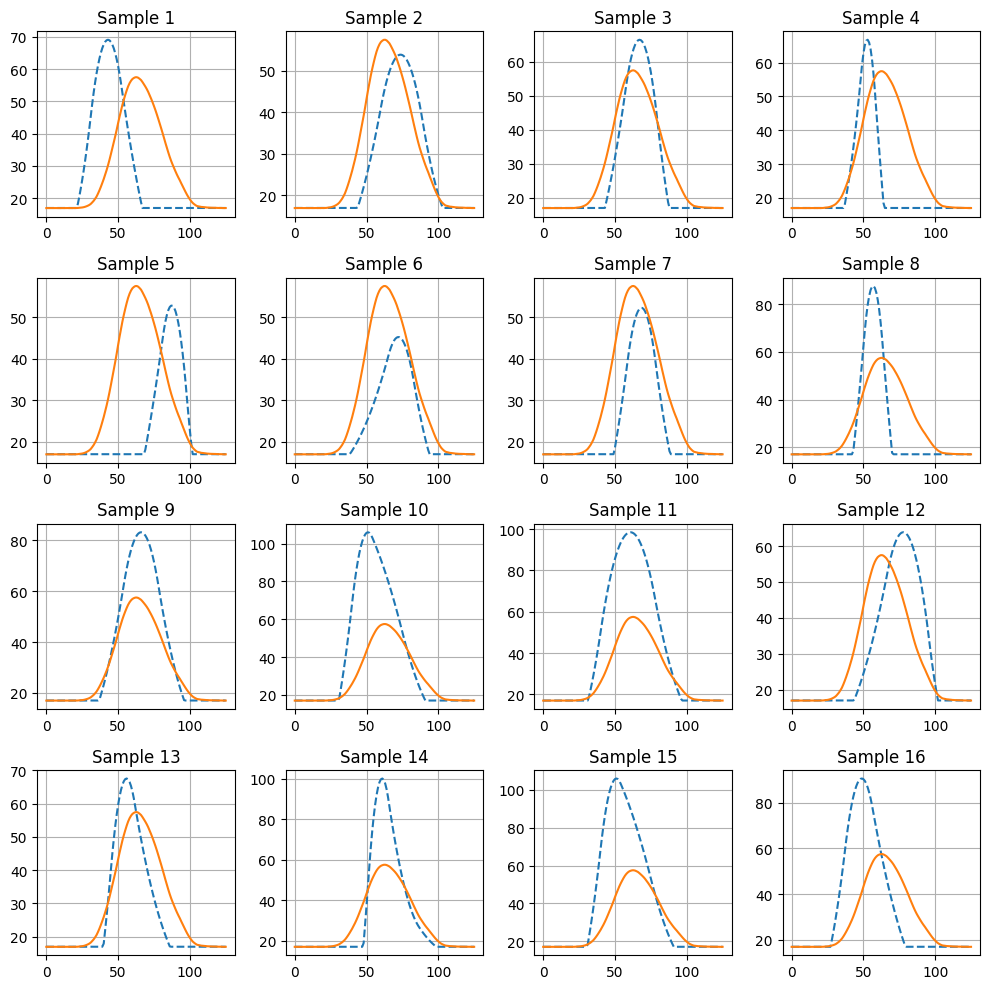

Test MSE: 238.7167
Test R²: -0.1424


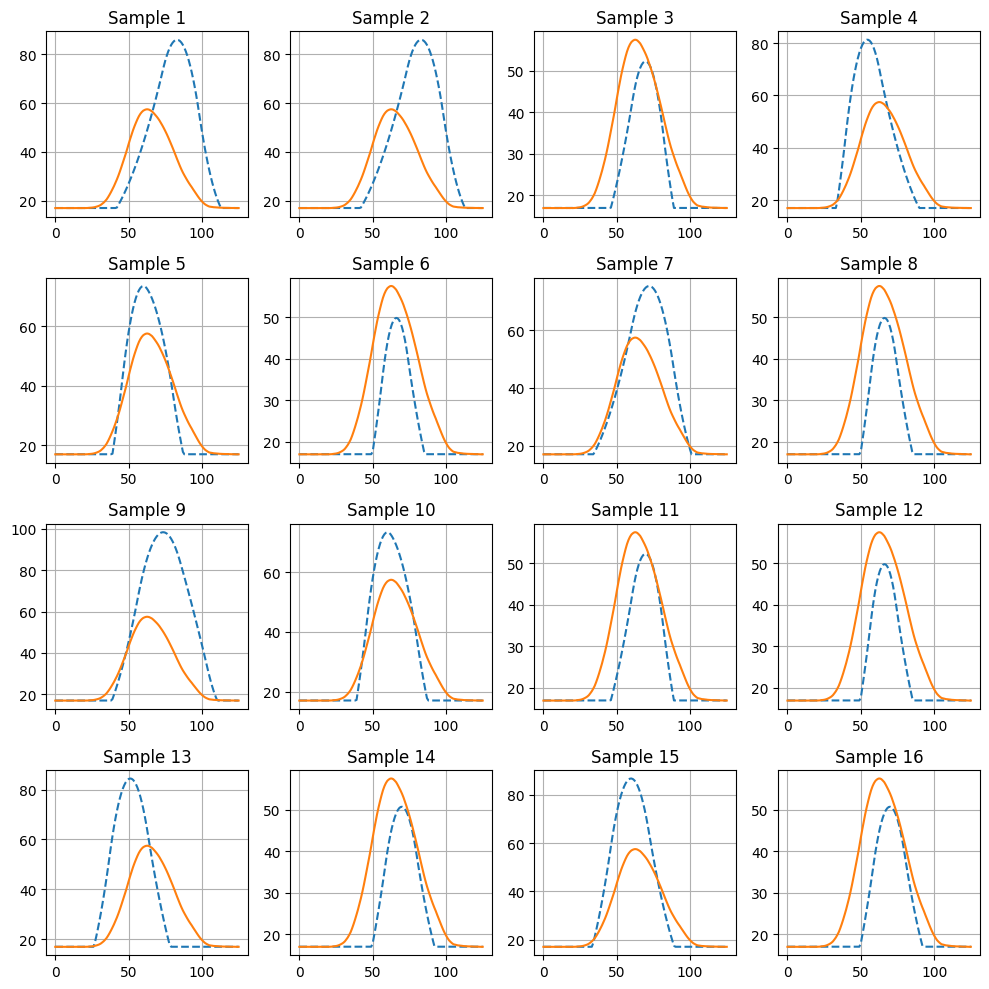

In [18]:
# Generate the plots and eval metrics

mse, r2,  predictions, ground_truths = evaluate_model(model, train_loader, device)
print(f"Train MSE: {mse:.4f}")
print(f"Train R²: {r2:.4f}")
plot_predictions(predictions, ground_truths, path='figs/swin_train.png')

mse, r2,  predictions, ground_truths = evaluate_model(model, test_loader, device)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

plot_predictions(predictions, ground_truths, path='figs/swin_test.png')


## Experiments end here

Code below is an attempt by the experimenters to debug the Swin Transformer model and not necessary to the core results.

In [16]:
class VarianceTracker:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.layer_stats = {}
        
    def hook_fn(self, name):
        def fn(module, input, output):
            if isinstance(output, torch.Tensor):
                # Reshape output to [batch_size, -1] to handle different layer shapes
                flat_output = output.view(output.size(0), -1)
                
                # Calculate variance between different samples in batch
                sample_means = flat_output.mean(dim=1)
                between_sample_var = sample_means.var()
                
                # Calculate average variance within samples
                within_sample_var = flat_output.var(dim=1).mean()
                
                self.layer_stats[name] = {
                    'between_sample_var': between_sample_var.item(),
                    'within_sample_var': within_sample_var.item(),
                    'shape': output.shape
                }
        return fn
    
    def register_hooks(self):
        # Clear any existing hooks
        self.remove_hooks()
        
        # Register new hooks
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Linear, nn.LayerNorm, nn.ReLU)):
                hook = module.register_forward_hook(self.hook_fn(name))
                self.hooks.append(hook)
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def analyze_batch(self, batch):
        self.layer_stats = {}
        
        # Forward pass
        with torch.no_grad():
            output = self.model(batch)
        
        # Print statistics
        print("\nLayer Variance Analysis:")
        print("-" * 50)
        for name, stats in self.layer_stats.items():
            print(f"\nLayer: {name}")
            print(f"Shape: {stats['shape']}")
            print(f"Between-sample variance: {stats['between_sample_var']:.8f}")
            print(f"Within-sample variance: {stats['within_sample_var']:.8f}")
            if stats['between_sample_var'] > 0:
                ratio = stats['within_sample_var'] / stats['between_sample_var']
                print(f"Within/Between ratio: {ratio:.4f}")
        
        return output

# Usage example:
tracker = VarianceTracker(model)
tracker.register_hooks()

# Get a batch of videos
batch_videos, _ = next(iter(train_loader))
batch_videos = batch_videos.to(device)

# Analyze the batch
_ = tracker.analyze_batch(batch_videos)

# Clean up
tracker.remove_hooks()


Layer Variance Analysis:
--------------------------------------------------

Layer: patch_embed.norm
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.04926629
Within/Between ratio: 150358239.1527

Layer: features.0.0.norm1
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.03307639
Within/Between ratio: 132344268.0367

Layer: features.0.0.norm2
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.80576730
Within/Between ratio: 721454558.4780

Layer: features.0.0.mlp.0
Shape: torch.Size([8, 13, 56, 56, 512])
Between-sample variance: 0.00000000
Within-sample variance: 0.10177027
Within/Between ratio: 1470698050516.2129

Layer: features.0.0.mlp.3
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.04143303
Within/Between ratio: 71767363542675.2031

Layer: features.0.1.norm1
Shape: torch.S